# News Article Sorting

News article classification is the task of assigning predefined categories to news articles based on their content. It leverages Natural Language Processing (NLP) and machine learning techniques to automatically categorize news articles into topics like sports, politics, technology, and others. This automation streamlines information organization, retrieval, and analysis, saving time and resources compared to manual classification.

Importing dependencies

In [1]:
import re
import pandas as pd

Reading Dataset

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/nikhil-xyz/datasets/refs/heads/main/bbc_text_cls.csv')

In [3]:
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [4]:
df.shape

(2225, 2)

In [5]:
df.labels.unique()

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [6]:
df.labels.value_counts()

,count
labels,
sport,511
business,510
politics,417
tech,401
entertainment,386


<Axes: xlabel='labels'>

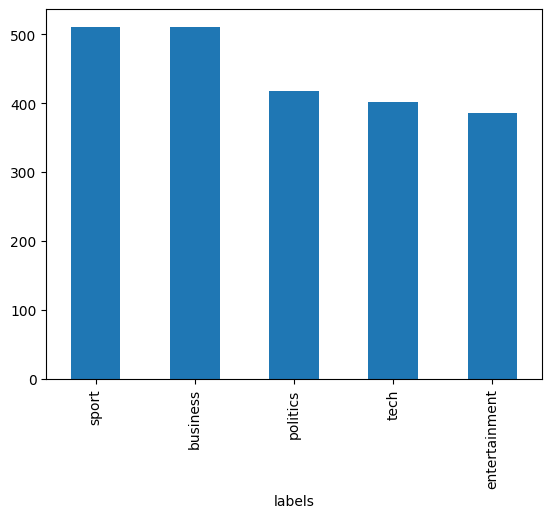

In [7]:
df.labels.value_counts().plot(kind='bar')

## Data Preprocessing
- **Regular Expressions :** Regular expressions (regex or regexp) are sequences of characters that define search patterns within text.
- **Stopwords :** Stopwords are commonly used words (like "the", "a", "is") that are often removed from text data during preprocessing for NLP tasks. Stopwords carry little semantic meaning and can overshadow more important words. Removing them helps reduce noise and improve model performance.
- **Lemmatization :** Lemmatization reduces words to their base or dictionary form (lemma). It considers the context and part of speech of words, unlike stemming. This helps group different inflected forms of a word, like "running" and "ran," under a common lemma "run." NLTK's WordNetLemmatizer is often used for this purpose.

In [8]:
import nltk
nltk.download('punkt')

from nltk.corpus import stopwords
nltk.download('stopwords')

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [13]:
import string
from nltk.tokenize import word_tokenize

In [14]:
def data_cleaning(text):
  text = text.lower()
  text = re.sub(r'(\d+)m', r'\1 million ', text)  # 7.5m -> 7.5 million
  text = re.sub(r'(\d+)bn', r'\1 billion ', text)
  text = re.sub(r"(\d+),(\d+)", r"\1\2", text)  # 146,000 -> 146000
  text = re.sub(r'(\d+).(\d+)', ' number ', text) # 145 -> number
  text = re.sub(r'(\d+)', ' number ', text)

  # text = text.replace('gmt', ' greenwich mean time ')
  text = text.replace('\n', '').replace("\'s", "").replace("\'",' ')
  text = text.replace('$', ' dollar ').replace('£', ' euro ').replace('%', ' percent ')
  text = text.replace('"', '').replace('.','')

  # tokenization
  tokens = word_tokenize(text)

  # removing stopwords
  tokens = [token for token in tokens if token not in stop_words]

  # removing punctuations
  tokens = [token for token in tokens if token not in string.punctuation]

  # Lemmatization
  lemmas = [lemmatizer.lemmatize(token) for token in tokens]
  sentence = ' '.join(lemmas)
  return sentence

In [15]:
df.text = df.text.apply(data_cleaning)

Replacing target labels with numbers

In [16]:
target_encoding = {'business' : 0, 'entertainment' : 1, 'politics' : 2, 'sport' : 3, 'tech' : 4}

In [17]:
df.labels = df.labels.map(target_encoding)

Spliting data into train and test set

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.labels, test_size=0.2, random_state=50)

In [23]:
X_train.shape, X_test.shape

((1780,), (445,))

In [24]:
y_train.shape, y_test.shape

((1780,), (445,))

In [25]:
max(df.text.apply(lambda x: len(x.split())))

2205

## Tokenization and Padding
- **Tokenization :** Tokenization is the process of breaking down text into smaller units called tokens. These tokens can be words, subwords, or characters, depending on the tokenizer used. Machine learning models work with numerical data. Tokenization converts text into a numerical representation that the model can understand.
- **Pad Sequences :**  pad_sequences is used to ensure that all sequences have the same length. This is necessary because neural networks often require input data to be in a fixed-size format.

In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

In [27]:
max_words = 200000  # Total number of tokens used to train the model
max_len = 2205 # Number of words in largest article

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

sequences = tokenizer.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

In [28]:
sequences_matrix

array([[    0,     0,     0, ...,    26,   564,   548],
       [    0,     0,     0, ...,   669,  3553, 15384],
       [    0,     0,     0, ...,   359,  1879,   635],
       ...,
       [    0,     0,     0, ...,  2913,  3386,   927],
       [    0,     0,     0, ..., 29253,   601, 15364],
       [    0,     0,     0, ...,  9326,   805,  8892]], dtype=int32)

## RNN Network
- **Embedding Layer :** Transforms word indices into dense vectors (word embeddings). Captures semantic relationships between words.
- **Bidirectional LSTM Layer :** Processes the sequence in both forward and backward directions. Learns long-term dependencies in the text.
- **Dense Layers (Feature Extractors) :** Multiple dense layers with ReLU activation extract features from the LSTM output. Increase the model's capacity to learn complex patterns.
- **Output Layer :** A dense layer with sigmoid activation outputs probabilities for each category. Used for multi-class classification.

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SpatialDropout1D, Bidirectional
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

In [30]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [31]:
model = Sequential()
# Create the embedding layer
model.add(Embedding(max_words, 128))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(128, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer
model.add(Dense(5, activation='sigmoid'))

In [32]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [33]:
# starting model training
history = model.fit(sequences_matrix, y_train, batch_size=128, epochs=12, validation_split=0.2)

Epoch 1/12
12/12 ━━━━━━━━━━━━━━━━━━━━ 221s 18s/step - accuracy: 0.2160 - loss: 1.6058 - val_accuracy: 0.3652 - val_loss: 1.5946
Epoch 2/12
12/12 ━━━━━━━━━━━━━━━━━━━━ 226s 19s/step - accuracy: 0.4131 - loss: 1.5756 - val_accuracy: 0.4270 - val_loss: 1.3690
Epoch 3/12
12/12 ━━━━━━━━━━━━━━━━━━━━ 219s 18s/step - accuracy: 0.5175 - loss: 1.1358 - val_accuracy: 0.5478 - val_loss: 1.0422
Epoch 4/12
12/12 ━━━━━━━━━━━━━━━━━━━━ 280s 19s/step - accuracy: 0.7208 - loss: 0.5812 - val_accuracy: 0.7416 - val_loss: 0.6744
Epoch 5/12
12/12 ━━━━━━━━━━━━━━━━━━━━ 245s 19s/step - accuracy: 0.9009 - loss: 0.2904 - val_accuracy: 0.7500 - val_loss: 0.7872
Epoch 6/12
12/12 ━━━━━━━━━━━━━━━━━━━━ 235s 20s/step - accuracy: 0.9699 - loss: 0.0792 - val_accuracy: 0.8230 - val_loss: 0.7252
Epoch 7/12
12/12 ━━━━━━━━━━━━━━━━━━━━ 257s 19s/step - accuracy: 0.9906 - loss: 0.0295 - val_accuracy: 0.7753 - val_loss: 1.0547
Epoch 8/12
12/12 ━━━━━━━━━━━━━━━━━━━━ 254s 19s/step - accuracy: 0.9964 - loss: 0.0095 - val_accuracy: 0.

In [34]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [35]:
lstm_prediction = model.predict(test_sequences_matrix)

14/14 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step


In [36]:
import numpy as np

In [37]:
pred = []
for prediction in lstm_prediction:
  pred.append(np.argmax(prediction))

In [59]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,pred)
cm

array([[96,  0,  7,  0,  5],
       [ 1, 60, 14,  2,  3],
       [ 0,  2, 59,  4,  1],
       [ 1,  1,  1, 94,  0],
       [ 1,  1, 20,  0, 72]])

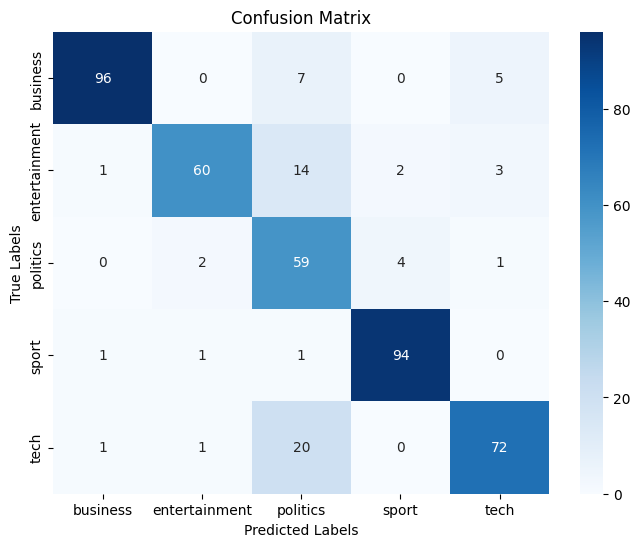

In [71]:
import seaborn as sns
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_encoding.keys(),
            yticklabels=target_encoding.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

plt.savefig('confusion_matrix.png')
plt.show()

## Performance Matrix
- **Accuracy:** Overall correctness of the model (total correct predictions / total predictions).
- **Precision:** Out of the positive predictions, how many were actually positive (true positives / (true positives + false positives)). Focuses on minimizing false positives.
- **Recall:** Out of the actual positives, how many were correctly predicted (true positives / (true positives + false negatives)). Focuses on minimizing false negatives.
- **F1-score:** Harmonic mean of precision and recall. Provides a balance between the two metrics.

Accuracy: 0.8561797752808988
Precision: 0.8831849072547704
Recall: 0.8561797752808988
F1-score: 0.8615559766211692


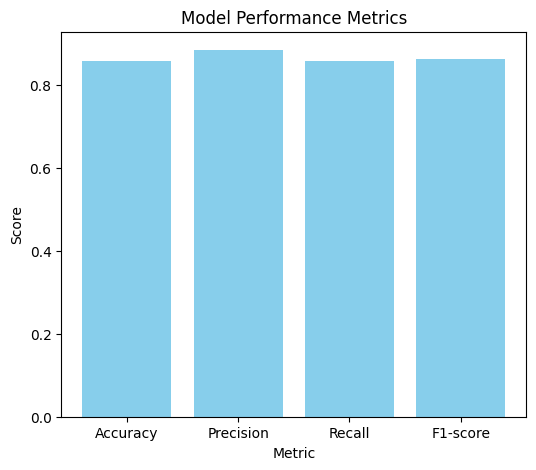

In [72]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred, average='weighted')  # Use 'weighted' for multi-class
recall = recall_score(y_test, pred, average='weighted')
f1 = f1_score(y_test, pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Create a dictionary to store the metrics and their values
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
}

# Create bar plot
plt.figure(figsize=(6, 5))  # Adjust figure size if needed
plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.title('Model Performance Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')

plt.savefig('model_performance_bar_plot.png')
plt.show()

business: 0.8888888888888888
entertainment: 0.75
politics: 0.8939393939393939
sport: 0.9690721649484536
tech: 0.7659574468085106


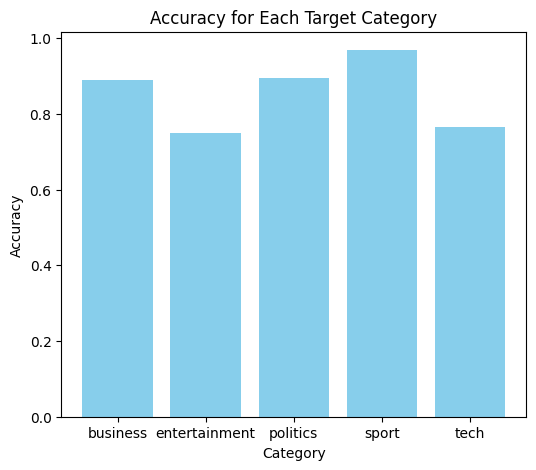

In [73]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

# Assuming 'y_test' and 'pred' are defined as in your provided code
# and 'target_encoding' maps category names to numerical labels

# Get unique labels
unique_labels = np.unique(y_test)

# Calculate accuracy for each category and store in a dictionary
category_accuracies = {}
for label in unique_labels:
    indices = np.where(y_test == label)[0]
    accuracy = accuracy_score(np.array(y_test)[indices], np.array(pred)[indices])

    # Get category name from target_encoding
    for category_name, category_label in target_encoding.items():
        if category_label == label:
            category_accuracies[category_name] = accuracy
            break
for category, accuracy in category_accuracies.items():
    print(f"{category}: {accuracy}")
# Create bar plot
plt.figure(figsize=(6, 5))
plt.bar(category_accuracies.keys(), category_accuracies.values(), color='skyblue')
plt.title('Accuracy for Each Target Category')
plt.xlabel('Category')
plt.ylabel('Accuracy')

plt.savefig('accuracy_bar_plot.png')
plt.show()

###**Creating MongoDB account and pushing the dataset over there**

MongoDB is a popular NoSQL database. It stores data in flexible, JSON-like documents. This makes it great for handling data that doesn't fit neatly into traditional rows and columns.

It's known for being scalable and easy to use, especially for developers working with data that changes frequently.

In [74]:
DB_NAME = "News_Articles"
COLLECTION_NAME = "news_data"

In [76]:
pip install pymongo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 21.1 MB/s eta 0:00:00


In [77]:
import os
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi

uri = os.getenv('MONGODB_URI')

# Create a new client and connect to the server
client = MongoClient(uri, server_api=ServerApi('1'))

# Send a ping to confirm a successful connection
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

localhost:27017: [Errno 111] Connection refused (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms), Timeout: 30s, Topology Description: <TopologyDescription id: 671f2767372188fa132689e5, topology_type: Unknown, servers: [<ServerDescription ('localhost', 27017) server_type: Unknown, rtt: None, error=AutoReconnect('localhost:27017: [Errno 111] Connection refused (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms)')>]>


In [79]:
data = pd.read_csv('https://raw.githubusercontent.com/nikhil-xyz/datasets/refs/heads/main/bbc_text_cls.csv')

In [80]:
data.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [78]:
data_base = client[DB_NAME]
collection = data_base[COLLECTION_NAME]

rec = collection.insert_many(data)

None
